In [0]:
# Run this only once whenever the notebook is opened and no drive is mounted
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# Run this if there is no gym-bubble-trouble repository
!cd drive/My\ Drive/ && git clone https://github.com/ferasboulala/gym-bubble-trouble.git

In [0]:
# Updating the repository and reinstalling the module
!cd drive/My\ Drive/gym-bubble-trouble && git pull origin master && pip install -e .
%cd drive/My\ Drive/gym-bubble-trouble

# Adding these paths to the system to import relevant modules (gym's setup does not work here)
import sys
sys.path.append('bubbletrouble')
sys.path.append('gym_bubbletrouble/envs')

!mkdir -p ../models

pygame 1.9.5
Hello from the pygame community. https://www.pygame.org/contribute.html


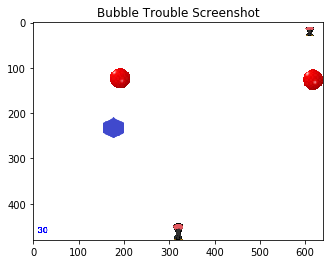

In [2]:
# OpenAI's gym
import gym
import gym.spaces

# BubbleTrouble environment
import bubbletrouble_env
from bubbletrouble_env import BubbleTroubleEnv
from settings import *

# std
import math
import random
import glob
import copy

# 3rd party
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import numpy as np
from IPython.display import clear_output
import cv2

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQCNN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.fc = nn.Linear(linear_input_size, linear_input_size)
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = torch.relu(self.fc(x.view(x.size(0), -1)))
        return self.head(x)
    
      
class DQN(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 4*n_inputs)
        self.fc2 = nn.Linear(4*n_inputs, 3*n_inputs)
        self.fc3 = nn.Linear(3*n_inputs, 2*n_inputs)
        self.fc4 = nn.Linear(2*n_inputs, 1*n_inputs)
        self.fc5 = nn.Linear(1*n_inputs, n_outputs)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        return self.fc5(x)


resize = T.Compose([T.ToPILImage(),
                    T.Resize(100, interpolation=Image.CUBIC),
                    T.ToTensor()])

def convert_screen(screen):
    return resize(screen).unsqueeze(0).to(device)

def convert_state(state):
    return torch.Tensor(state).unsqueeze(0).to(device)
  
    
# The following line does not work in colab
# env = gym.make('gym_bubbletrouble:BubbleTrouble-v0')

K = 5  # How many balls to track
FRAME_SKIP = 3  # For efficient training, an action lasts FRAME_SKIP frames

# Used for the reward function
reward_dict = {'moving': .0, 'fire': .0, 'score': 100., 'death': -1., 'win': .0, 'step': .0}

# Set it to False if we are training the MLP
training_cnn = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = BubbleTroubleEnv(rewards=reward_dict, K=K, rand=True, timed=True)
env.reset()
plt.figure()
plt.imshow(env.render(), interpolation='none')
plt.title('Bubble Trouble Screenshot')
plt.show()

init_screen = convert_screen(env.render())
_, _, screen_height, screen_width = init_screen.shape
n_actions = env.action_space.n
n_inputs = K * 5 + 4

In [0]:
def select_action(state, model, infer=False):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > 0.2 or infer:
        with torch.no_grad():
            return model(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


def optimize_model(policy_net, target_net, optimizer):
    if len(memory) < BATCH_SIZE:
        return 0
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = None
    non_final_next_states = None

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch.type(torch.float)

    loss = loss_function(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    return loss.item()

def tag_player(pos, image):
    H, W, _ = image.shape
    
    x = pos * W
    y = H
    
    x0 = x - W * PLAYER_WIDTH
    x1 = x + W * PLAYER_WIDTH
    
    y0 = int((1 - PLAYER_HEIGHT) * H)
    y1 = int(H)
    
    x0 = int(max(0, x0))
    x1 = int(min(W, x1))

    image[y0:y1, x0:x1] = 1.0, 1.0, 1.0
    
    return image

def load_retrain():
    policy_net = None
    target_net = None
    
    if training_cnn:
        policy_net = DQCNN(screen_height, screen_width, n_actions).to(device)
    else:
        policy_net = DQN(n_inputs, n_actions).to(device)

    checkpoint = torch.load(MODEL_FN)
    policy_net.load_state_dict(checkpoint['model'])
    
    optimizer = optim.RMSprop(policy_net.parameters())
    optimizer.load_state_dict(checkpoint['optimizer'])
    
    target_net = copy.deepcopy(policy_net)
    target_net.eval()
    
    return policy_net, target_net, optimizer

In [0]:
BATCH_SIZE = 64
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 50000
TARGET_UPDATE = 20
CHECKPOINT = 10

MODEL_FN = '../models/bubble-trouble-dqn'
if training_cnn:
    MODEL_FN += '-cnn'

policy_net = None
target_net = None

if training_cnn:
    policy_net = DQCNN(screen_height, screen_width, n_actions).to(device)
    target_net = DQCNN(screen_height, screen_width, n_actions).to(device)
else:
    policy_net = DQN(n_inputs, n_actions).to(device)
    target_net = DQN(n_inputs, n_actions).to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
loss_function = nn.MSELoss()
memory = ReplayMemory(20000)

episode_durations = []
rewards = []
steps_done = 0

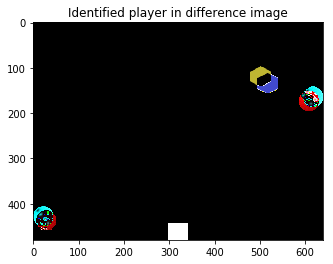

In [15]:
env.reset()
plt.figure()
beg = env.render()
for _ in range(FRAME_SKIP):
    env.step(3)
end = env.render()
plt.imshow(tag_player(0.5, (end - beg) / 255))
plt.title('Identified player in difference image');

In [0]:
num_episodes = 100000
for i_episode in range(num_episodes):
    env.reset()
    
    state = None
    next_state = None
    last_state = None
    current_screen = None
    last_screen = None
    
    if training_cnn:
        last_screen = convert_screen(env.render())
        current_screen = last_screen
        state = current_screen - last_screen
    else:
        state, _, _, _ = env.step(3)
        state = convert_state(state)
        last_state = state
        
    cum_reward = 0.
    t = 0
    while True:
        action = select_action(state, policy_net)   
        reward = 0
        for i in range(FRAME_SKIP):
            t += 1
            state, r, done, _ = env.step(action.item())
            reward += r
        
        player_position = state[2]
        state = convert_state(state)
        reward = torch.tensor([reward], device=device)
        cum_reward += reward.item()

        if training_cnn:
            state = current_screen - last_screen
            last_screen = current_screen
            current_screen = convert_screen(env.render())
            
            if not done:
                next_state = current_screen - last_screen
                state_np = next_state.cpu().squeeze(0).permute(1, 2, 0).numpy().astype(np.uint8) 
                state = tag_player(player_position, state_np)
                state = convert_screen(state)
            else:
                next_state = None
            memory.push(state, action, next_state, reward)
        else:
            if done:
                state = None
            memory.push(last_state, action, state, reward)
            last_state = state

        optimize_model(policy_net, target_net, optimizer)
        
        if done:
            score = cum_reward
            episode_durations.append(t + 1)
            rewards.append(score)
            clear_output(wait=True)
            print('[{}] Reward : {}, Steps : {}, Efficiency : {:.3f}'
                  .format(i_episode + 1, cum_reward, t + 1, score / (t + 1)))
            break
            
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())  
        
    if i_episode % CHECKPOINT == 0:
        torch.save({'model': policy_net.state_dict(), 
                    'optimizer': optimizer.state_dict()}, MODEL_FN)
        np.save('../scores', np.array(rewards))
        np.save('../durations', np.array(episode_durations))

print('Complete')

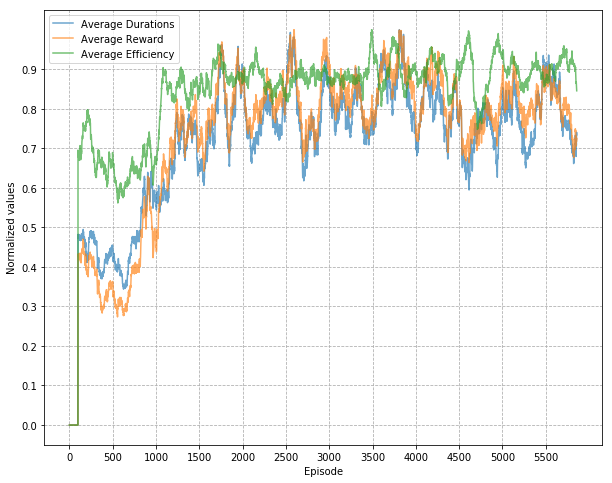

In [116]:
def plot_data(data, label, new_plot=True):
    if len(data) < 100:
        raise ValueError('Not enough data points')
    data = torch.tensor(data, dtype=torch.float)

    if new_plot:
        plt.figure(figsize=(10,8))
        plt.clf()
    data_np = data.numpy()
    means = data.unfold(0, 100, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(99), means)).numpy()
    plt.plot(means / np.max(means), label='Average ' + label, alpha=0.66)
    plt.legend(loc='best')
    plt.xlabel('Episode')
    plt.ylabel('Normalized values')
    plt.xticks(np.arange(0, len(data), 500))
    plt.yticks(np.arange(0, 1, 0.1))
    plt.grid(linestyle='--')
        
def plot_durations(durations):
    plot_data(durations, 'Durations', True)
    
def plot_rewards(rewards):
    plot_data(rewards, 'Reward', False)
        
def plot_efficiency(rewards, durations,):
    rewards_copy = np.array(rewards)
    rewards_copy[rewards_copy < 0] = 0
    relative_rewards = rewards_copy / np.array(durations) + 1
    relative_rewards = np.log(relative_rewards)
    plot_data(relative_rewards, 'Efficiency', False)

plot_durations(episode_durations)
plot_rewards(rewards)
plot_efficiency(rewards, episode_durations)

In [44]:
model = None
if training_cnn:
    model = DQCNN(screen_height, screen_width, n_actions).to(device)
else:
    model = DQN(n_inputs, n_actions).to(device)

checkpoint = torch.load(MODEL_FN)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
model.eval()

DQCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=4032, out_features=4032, bias=True)
  (head): Linear(in_features=4032, out_features=4, bias=True)
)

In [0]:
env.reset()

last_screen = convert_screen(env.render())
current_screen = last_screen
state = current_screen - last_screen

if not training_cnn:
    state, _, _, _ = env.step(3)
    state = convert_state(state)
    
img_array = []
delta_array = []
cum_reward = 0
for i in range(bubbletrouble_env.MAX_N_STEPS):    
    action = select_action(state, model=target_net, infer=True)
    for _ in range(2):
        img_array.append(env.render()) # Taking the high res image.
        state, r, done, _ = env.step(action.item())
        cum_reward += r
        
    state = convert_state(state)
    
    last_screen = current_screen
    current_screen = convert_screen(env.render())

    if training_cnn:
        state = current_screen - last_screen
    if done:
        break

print('Finished with {} reward and {} steps'.format(cum_reward, i))
      
# Call this only when you are sure you won't be using the model anymore.
# There is a pygame bug with fonts where if you quit, it will not restart.
######## env.close()

In [0]:
# Saving the playback
out = cv2.VideoWriter(
    '../models/dqn-result.mp4',
    cv2.VideoWriter_fourcc(*'DIVX'), 
    30, 
    (640, 480)
)

for img in img_array:
    img_norm = cv2.cvtColor(np.uint8(img), cv2.COLOR_BGR2RGB)
    out.write(img_norm)
out.release()